<a href="https://colab.research.google.com/github/Viroslav/CV_final_task/blob/main/Final_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Your task is to find the shaded segmentation mask.
Check out the guidelines_of_first_20_images folder. This folder is to illustrate and guide you for better understanding on the problem. 

You have to write an algorithm that will solve the following problem. Here are the instructions for your algorithm.

Inputs for the algorithm are in the dataset folder:
1. Image raw (the image folder)
2. Human parsing of the image 
3. Pose estimation of the person (both json and image) [*1]

Output:
1. The person's image with gray shaded region. Look at the sample_output.jpg for details.

Note: you don't have to use all the inputs given to you. You may use only those inputs that you find important for your algorithm to work better.



[*1]
body25 + hands labelling, check out the openpose labels for more details if you want.

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Final_task/Task'

## imports

In [3]:
import torch
import json
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from skimage.transform import rescale, ProjectiveTransform, warp
import pickle
import pandas as pd
import random
from skimage import io
from scipy import ndimage
from pylab import imshow

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from matplotlib import cm
from skimage.feature import canny
import imutils
from sklearn.metrics import accuracy_score

import warnings
import os
import torch
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


%matplotlib inline
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Auxiliary Functions

In [4]:
def show(img, cmap=None, axis_of = "off"):
    """
    function to plot image
    """
    
    plt.figure(figsize=(14,8))
    plt.imshow(img, cmap=cmap)
    plt.axis(axis_of)
    plt.show()

## work with data

In [5]:
%%time
human_parsing = {}
for img in os.listdir(path + '/dataset/human_parsing/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        human_parsing[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/human_parsing/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(human_parsing)} photos of human_parsing completed')

All 704 photos of human_parsing completed
CPU times: user 4.76 s, sys: 1.86 s, total: 6.62 s
Wall time: 18.9 s


In [6]:
%%time
image = {}
for img in os.listdir(path + '/dataset/image/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        image[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/image/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(image)} photos of image completed')

All 704 photos of image completed
CPU times: user 8.98 s, sys: 1.74 s, total: 10.7 s
Wall time: 21.8 s


In [7]:
%%time
pose_jpg = {}
for img in os.listdir(path + '/dataset/pose_img/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        pose_jpg[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/pose_img/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(pose_jpg)} photos of pose_jpg completed')

All 704 photos of pose_jpg completed
CPU times: user 7.72 s, sys: 1.74 s, total: 9.46 s
Wall time: 20.2 s


In [8]:
%%time
pose_json = {}
for key_p in os.listdir(path + '/dataset/pose_json/'):
    if key_p[-5:].lower() == '.json':
        # print(f' Loading: {key_p}')
        with open(f'{path}/dataset/pose_json/{key_p}', 'r') as f:
            pose_json[key_p]  = json.load(f)
print(f'All {len(pose_json)} of pose_json completed')

All 704 of pose_json completed
CPU times: user 201 ms, sys: 110 ms, total: 310 ms
Wall time: 9.58 s


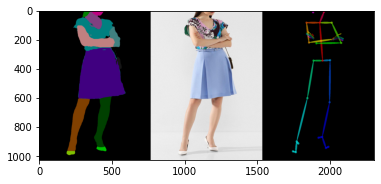

In [9]:
imshow(np.hstack([human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png']]))

## Thoughts

Use the points of the pelvis, complete the trapezoid to the ankles, subtract the mask of the hands from this

## Json_adjustment

In [10]:
list_of_points_name = ["Nose", "Neck", "LShoulder", "LElbow", "LWrist", "RShoulder", "RElbow", "RWrist", 
                       "MidHip", "LHip", "LKnee", "LAnkle", "RHip", "RKnee", "RAnkle", "LEye", "REye",
                       "LEar", "REar", "RBigToe", "RSmallToe", "RHeel", "LBigToe", "LSmallToe", "LHeel"]

def to_test_json(pose_json):
    right_json = {}
    keypoints = pose_json['people'][0]['pose_keypoints_2d']
    # reshape the data into (x, y) pairs
    keypoints = [keypoints[i:i+3] for i in range(0, len(keypoints), 3)]
    x = [point[0] for point in keypoints]
    y = [point[1] for point in keypoints]
    point_xy = list(zip(x, y)) 
    for i in range(25):
        right_json[list_of_points_name[i]] = (int(point_xy[i][0]), int(point_xy[i][1]))

    return right_json

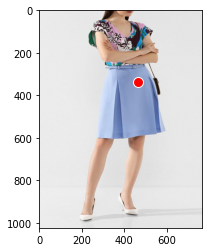

In [11]:
q = to_test_json(pose_json['168762_00_keypoints.json'])
img = image['168762_00.jpg']
# plot the image
fig, ax = plt.subplots()
ax.imshow(img)
# plot the keypoints on top of the image

ax.scatter(q['RHip'][0], 
           q['RHip'][1], c="red", s=100, edgecolors="white") 

plt.axis("on")
plt.show()

## dress coordinates in binary mask

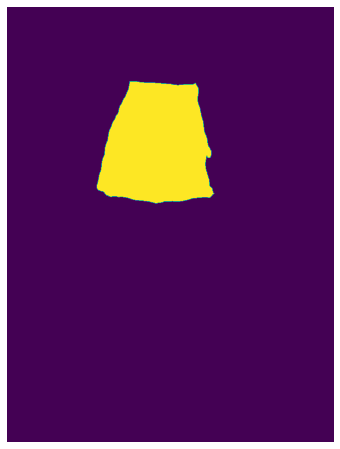

[(288, 175), (212, 428), (476, 448), (443, 180)]

In [12]:
def binary_mask(human_parsing):
    human_parsing = cv2.cvtColor(human_parsing, cv2.COLOR_RGB2GRAY)
    unique_values = np.unique(human_parsing)
    #print(unique_values)
    list_of_cont_trash = [19, 22, 53, 72, 75, 90, 109, 113, 147, 151]
    list_of_count_needed = [34]
    #for value in unique_values:
    #for value in list_of_cont_trash:
    for value in list_of_count_needed:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        #show(binary_mask, cmap = 'gray')
    return binary_mask

p = binary_mask(human_parsing['48398_00.png'])
show(p)

def find_dress_contour_points(p):
    # Find the contour of the binary mask
    contours, _ = cv2.findContours(p.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Approximate the contour as a polygon
    epsilon = 0.1 * cv2.arcLength(contours[0], True)
    approx = cv2.approxPolyDP(contours[0], epsilon, True)

    # Find the corners of the polygon
    corners = np.int0(approx)

    # Extract the x and y positions of the corners
    x_pos = corners[:, 0, 0]
    y_pos = corners[:, 0, 1]

    v = list(zip(x_pos, y_pos))
    return v

dress = find_dress_contour_points(p)
dress

(array([212, 428]), array([476, 448]))


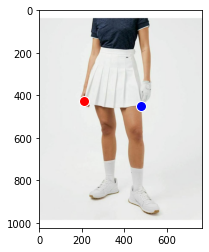

In [13]:
def find_edges_of_dress(lt):
    coords = np.array(lt)
    bottom_left = coords[np.argmin(coords[:, 0]), :]
    bottom_right = coords[np.argmax(coords[:, 0]), :]

    return bottom_left, bottom_right


lop = find_edges_of_dress(dress)
print(lop)
img = image['48398_00.jpg']
# plot the image
fig, ax = plt.subplots()
ax.imshow(img)
# plot the keypoints on top of the image

ax.scatter(lop[0][0], 
           lop[0][1], c="red", s=100, edgecolors="white")
ax.scatter(lop[1][0], 
           lop[1][1], c="blue", s=100, edgecolors="white")

plt.axis("on")
plt.show()

## shaded_segmentation_mask_1(draw between key_points)

In [14]:
from scipy.constants import point
def shaded_segmentation_mask(human_parsing, image, pose_json):
    
#-----------------------------------------------------------------------------#
    # Get the edges of the dress
    p = binary_mask(human_parsing)
    show(p)
    dress = find_dress_contour_points(p)
    
    dress = find_edges_of_dress(dress)
    #print(dress)
    dress_l_x, dress_l_y = int(dress[0][0]), int(dress[0][1])
    dress_r_x, dress_r_y = int(dress[1][0]), int(dress[1][1])
    #print((dress_l_x, dress_l_y), (dress_r_x, dress_r_y))
  
#-----------------------------------------------------------------------------#
    # Get the coordinates of the pelvis keypoints
    pelvis_left_point = pose_json["LHip"]
    pelvis_right_point = pose_json["RHip"]
    pelvis_left_x, pelvis_left_y = int(pelvis_left_point[0]), int(pelvis_left_point[1])
    pelvis_right_x, pelvis_right_y = int(pelvis_right_point[0]), int(pelvis_right_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the right ankles keypoints
    # right 
    ankle_r_r_point = pose_json["RAnkle"]
    ankle_r_r_x, ankle_r_r_y = int(ankle_r_r_point[0]) + 50, int(ankle_r_r_point[1])
    # left
    ankle_r_l_point = pose_json["RHeel"]
    ankle_r_l_x, ankle_r_l_y = int(ankle_r_l_point[0]), int(ankle_r_l_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the left ankles keypoints
    # right 
    ankle_l_r_point = pose_json["LAnkle"]
    ankle_l_r_x, ankle_l_r_y = int(ankle_l_r_point[0]), int(ankle_l_r_point[1])
    # left
    ankle_l_l_point = pose_json["LHeel"]
    ankle_l_l_x, ankle_l_l_y = int(ankle_l_l_point[0]) - 50, int(ankle_l_l_point[1])
#-----------------------------------------------------------------------------#    
    # Get the coordinates of the knees keypoints
    knee_l_point = pose_json["LKnee"]
    knee_r_point = pose_json["RKnee"]
    knee_l_x, knee_l_y = int(knee_l_point[0]) - 50, int(knee_l_point[1])
    knee_r_x, knee_r_y = int(knee_r_point[0]) + 50, int(knee_r_point[1])
#-----------------------------------------------------------------------------#
    # Create a mask representing the body of the person
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    
    potential_way = [[pelvis_right_x, pelvis_right_y], [dress_r_x, dress_r_y], [knee_r_x, knee_r_y], 
                     [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                     [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], 
                     [knee_l_x, knee_l_y], [dress_l_x, dress_l_y], [pelvis_left_x, pelvis_left_y]]

    # adjust posture for knee position
    if knee_r_x > ankle_r_r_x or knee_l_x < ankle_l_l_x:
        #print('yes')
        # Create additional point
        add_r_x, add_r_y = knee_r_x+10, ankle_r_r_y
        add_l_x, add_l_y = knee_l_x-10, ankle_l_l_y
        potential_way = [[pelvis_right_x, pelvis_right_y], [dress_r_x, dress_r_y], [knee_r_x, knee_r_y], [add_r_x, add_r_y],
                     [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                     [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], [add_l_x, add_l_y], 
                     [knee_l_x, knee_l_y], [dress_l_x, dress_l_y], [pelvis_left_x, pelvis_left_y]]
        
        if pelvis_right_x == 0 or pelvis_right_y == 0:
                    #print('this case')
                    potential_way = [[dress_r_x, dress_r_y], [knee_r_x, knee_r_y], 
                     [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                     [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], [add_l_x, add_l_y],
                     [knee_l_x, knee_l_y], [dress_l_x, dress_l_y], [pelvis_left_x, pelvis_left_y]]

        for j in potential_way:
            if j[0] != 0 or j[1] != 0:
                  #print(j)
                  potential_way.remove(j)

        if knee_r_x > ankle_r_r_x and knee_l_x < ankle_l_l_x:
            #print('knee_r_x > ankle_r_r_x and knee_l_x < ankle_l_l_x')
            cv2.fillConvexPoly(mask, np.array(potential_way), 1)
        else:
            if knee_r_x > ankle_r_r_x:
                #print('knee_r_x > ankle_r_r_x')
                potential_way = [[pelvis_right_x, pelvis_right_y], [dress_r_x, dress_r_y], [knee_r_x, knee_r_y], 
                     [add_r_x, add_r_y],[ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                     [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], 
                     [knee_l_x, knee_l_y], [dress_l_x, dress_l_y], [pelvis_left_x, pelvis_left_y]]
                for j in potential_way:
                    if j[0] != 0 or j[1] != 0:
                          #print(j)
                          potential_way.remove(j)
                cv2.fillConvexPoly(mask, np.array(potential_way), 1)

            elif knee_l_x < ankle_l_l_x:
                #print('knee_l_x < ankle_l_l_x')
                potential_way = [[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y], 
                     [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                     [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], [add_l_x, add_l_y],
                     [knee_l_x, knee_l_y], [dress_l_x, dress_l_y], [pelvis_left_x, pelvis_left_y]]

                for j in potential_way:
                    if j[0] != 0 or j[1] != 0:
                          #print(j)
                          potential_way.remove(j)

                cv2.fillConvexPoly(mask, np.array(potential_way), 1)


    else:
        #print('no')
        cv2.fillConvexPoly(mask, np.array(potential_way), 1)

    # Subtract the hands mask from the body mask
    hands_mask = np.logical_and(human_parsing == 17, human_parsing == 18)
    mask = np.logical_xor(mask, hands_mask[:, :, 1])

    # Combine the body mask with the human parsing mask
    final_mask = np.logical_or(mask, human_parsing[:, :, 1])

    return mask

## segment looping using cycles

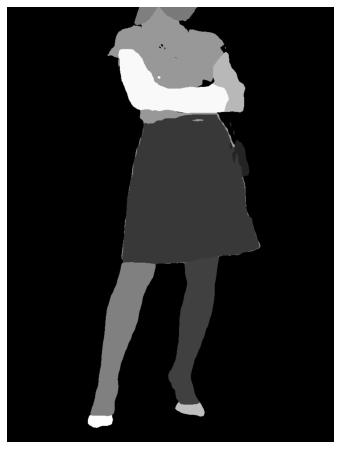

[  0  22  34  38  72  75  76  90 109 113 147 151]


In [15]:
human_parsing_test = cv2.cvtColor(human_parsing['168762_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

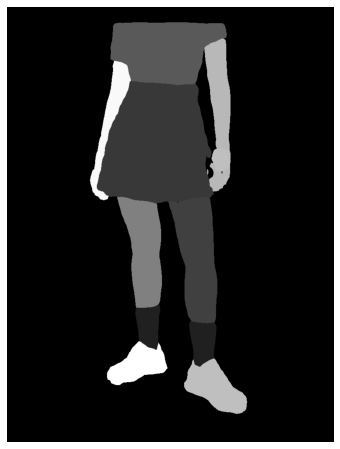

[  0  19  34  38  53  76 109 113 147 151]


In [16]:
human_parsing_test = cv2.cvtColor(human_parsing['48398_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

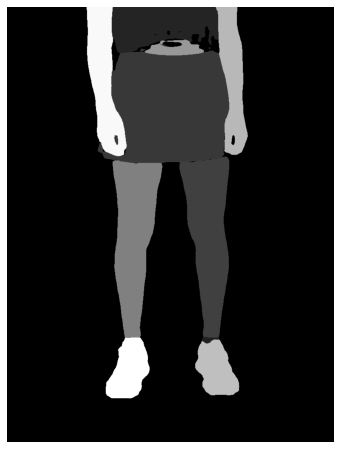

[  0  19  22  34  38  76  90 109 113 147 151]


In [17]:
human_parsing_test = cv2.cvtColor(human_parsing['48365_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

In [18]:
def shaded_segmentation_mask_2(image, human_parsing, pose_json):
    mask = np.zeros_like(image[:, :, 0])

    pose_json_need = [pose_json["LHip"],   pose_json["RHip"],
                      pose_json["RAnkle"], pose_json["RHeel"],
                      pose_json["LAnkle"], pose_json["LHeel"],
                      pose_json["LKnee"],  pose_json["RKnee"]]             
    print(pose_json_need)
    print(np.unique(human_parsing))
    list_of_count_needed = [34, 38, 76]
    list_of_cont_trash = [19, 22, 53, 72, 75, 90, 109, 113, 147, 151]

    for x, y in pose_json_need:
        # Check if the point falls into the body part or clothes region in the human parsing mask
        #if human_parsing[int(y), int(x)] in np.unique(human_parsing):
        if (human_parsing[int(y), int(x)] in list_of_count_needed) or (human_parsing[int(y)+10, int(x)] in list_of_count_needed):
            if (human_parsing[int(y), int(x)] in list_of_count_needed):
                # If the point falls into a body part or clothes region, include it in the mask
                mask[human_parsing == human_parsing[int(y), int(x)]] = 1
                #show(mask)
            elif (human_parsing[int(y)+10, int(x)] in list_of_count_needed):
                mask[human_parsing == human_parsing[int(y)+10, int(x)]] = 1
                #show(mask)
            
    # Apply morphological operations to fill in the gaps in the mask
    #kernel = np.ones((5, 5), np.uint8)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

[(312, 487), (434, 490), (402, 915), (394, 929), (306, 913), (323, 921), (292, 731), (422, 711)]
[  0  34  38  53  72  75  76  90 109 113 147 151]


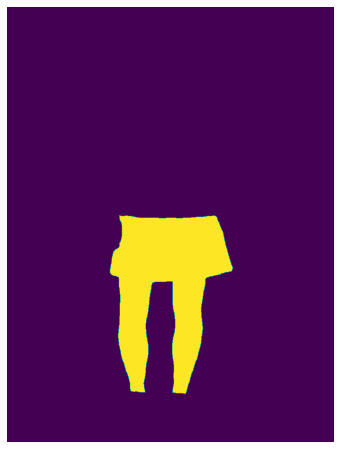

In [19]:
human_parsing_test = cv2.cvtColor(human_parsing['48388_00.png'], cv2.COLOR_RGB2GRAY)
t = shaded_segmentation_mask_2(image['48388_00.jpg'], human_parsing_test, to_test_json(pose_json['48388_00_keypoints.json']))
show(t)

## plot_with_shade

In [34]:
def plot_with_shade(image, total):
    masked_image = np.copy(image)
    masked_image[:,:,0][total == 1] = 105
    masked_image[:,:,1][total == 1] = 105
    masked_image[:,:,2][total == 1] = 105

    # plot the original image and the masked image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Original image')
    ax[1].imshow(masked_image)
    ax[1].set_title('Masked image')
    plt.show()

## Total Function

In [35]:
def total_func(image, human_parsing, pose_json):
    pose_json = to_test_json(pose_json)
    test = shaded_segmentation_mask(human_parsing, image, pose_json)
    show(test, cmap='gray')
    human_parsing_test = cv2.cvtColor(human_parsing, cv2.COLOR_RGB2GRAY)
    show(human_parsing_test, cmap='gray')
    test_show = shaded_segmentation_mask_2(image, human_parsing_test, pose_json)
    show(test_show, cmap='gray')
    total = test + test_show
    show(total, cmap='gray')

    # set the values of the gray pixels to 1 (white)
    gray_indices = np.where(total == 2)
    total[gray_indices] = 1
    show(total, cmap='gray')
    # Fill any holes in the mask
    filled_mask = ndimage.morphology.binary_fill_holes(total).astype(np.uint8)
    interior_mask = np.logical_not(filled_mask).astype(np.bool)
    total[interior_mask] = 0
    stacked_masks = filled_mask * 255
    gray_indices = np.where(stacked_masks == 255)
    stacked_masks[gray_indices] = 1
    show(stacked_masks, cmap='gray')
    plot_with_shade(image, stacked_masks)
    return total

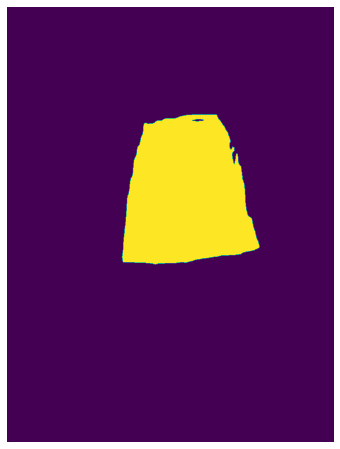

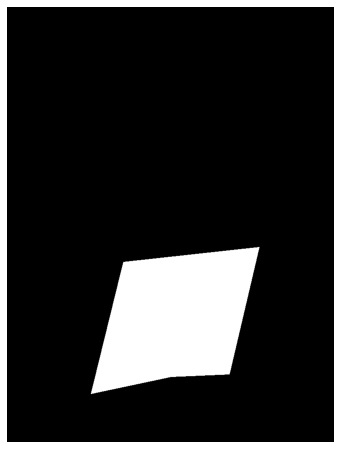

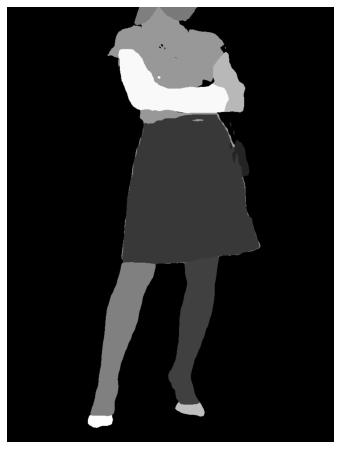

[(351, 340), (465, 337), (411, 864), (385, 870), (235, 896), (247, 910), (309, 598), (462, 626)]
[  0  22  34  38  72  75  76  90 109 113 147 151]


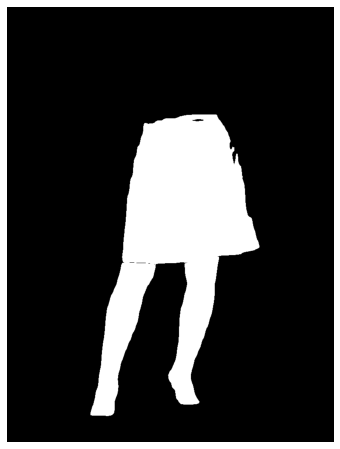

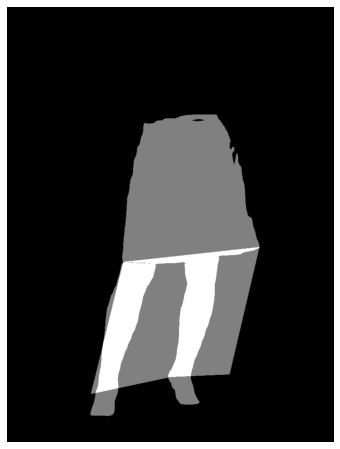

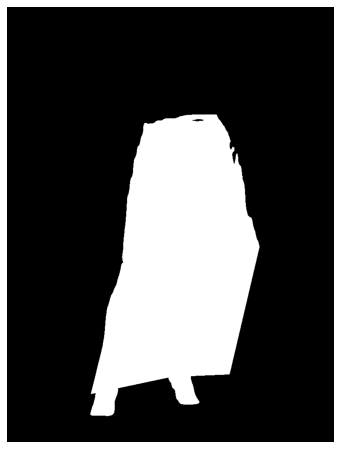

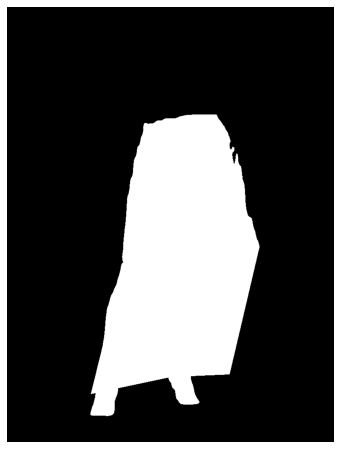

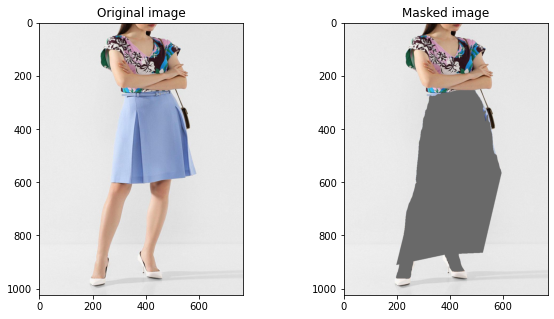

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [36]:
total_func(image['168762_00.jpg'], human_parsing['168762_00.png'], pose_json['168762_00_keypoints.json'])

## plot all together

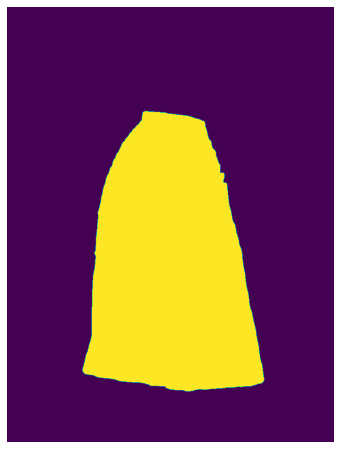

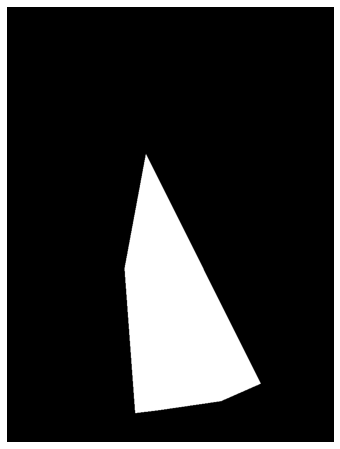

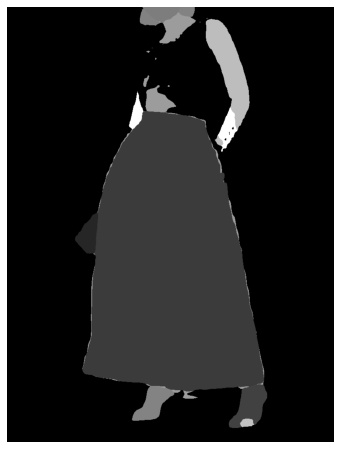

[(326, 346), (420, 354), (349, 927), (351, 949), (349, 929), (351, 955), (326, 615), (442, 592)]
[  0  22  34  38  72  75  76  90 109 113 147]


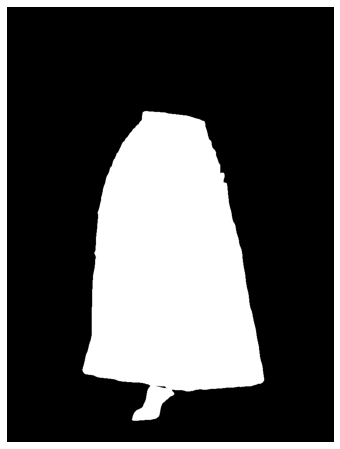

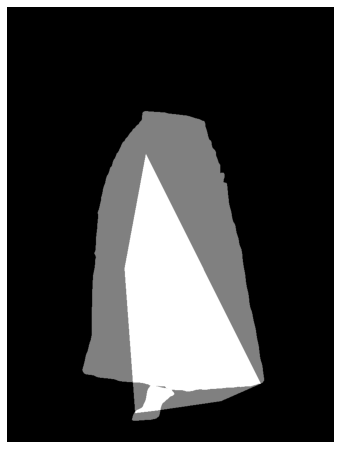

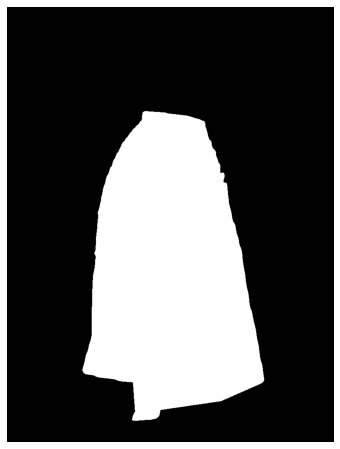

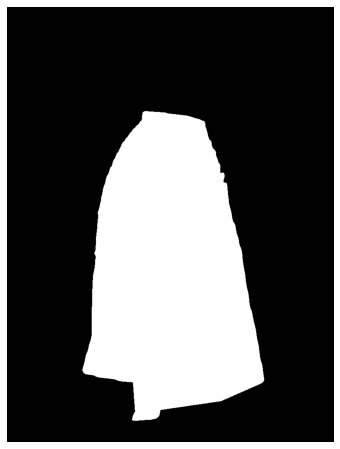

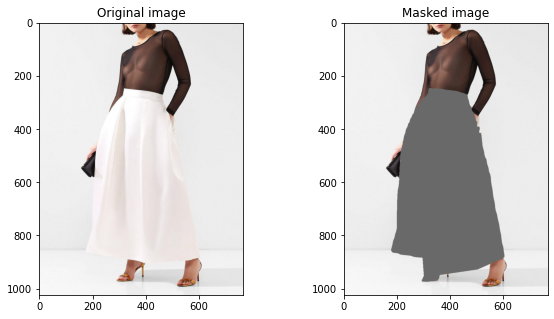

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
total_func(image['178487_00.jpg'], human_parsing['178487_00.png'], pose_json['178487_00_keypoints.json'])

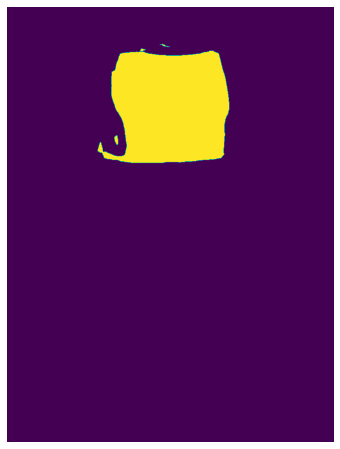

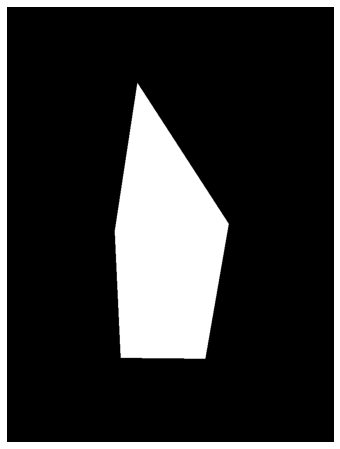

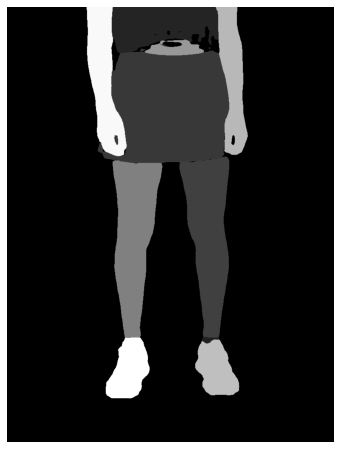

[(306, 179), (459, 187), (484, 805), (465, 827), (300, 805), (317, 825), (303, 527), (470, 510)]
[  0  19  22  34  38  76  90 109 113 147 151]


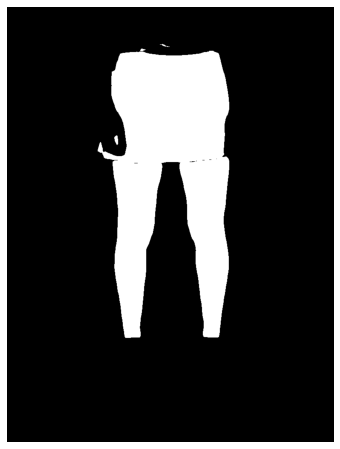

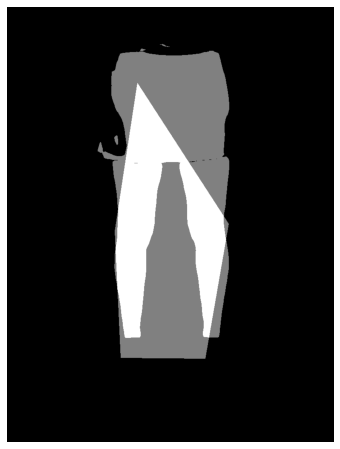

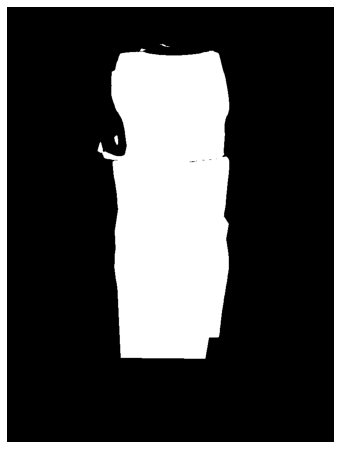

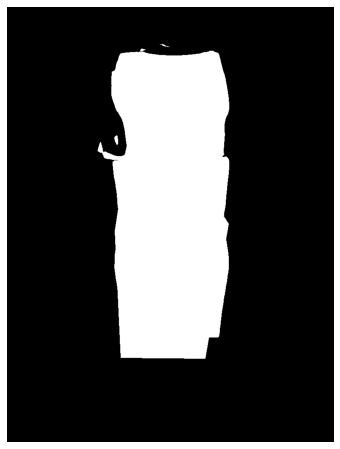

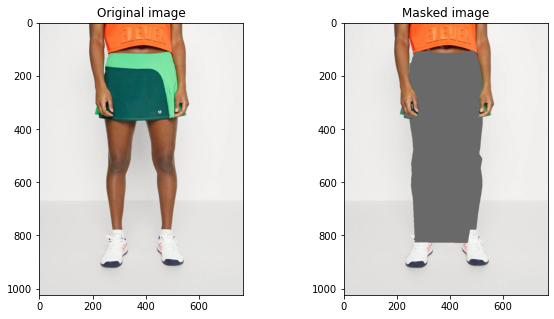

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [38]:
total_func(image['48365_00.jpg'], human_parsing['48365_00.png'], pose_json['48365_00_keypoints.json'])

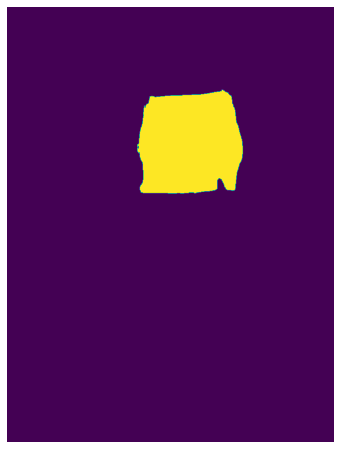

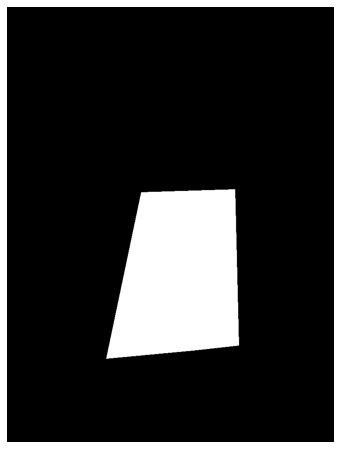

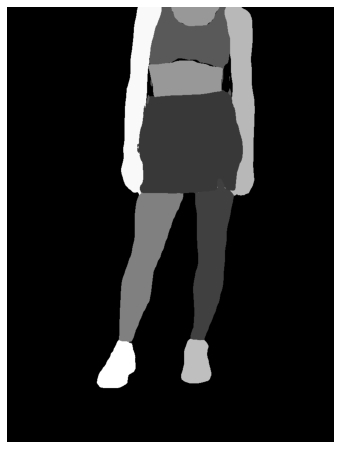

[(371, 300), (488, 306), (442, 796), (436, 808), (278, 808), (283, 827), (323, 581), (484, 570)]
[  0  19  34  38  53  76  90 109 113 147 151]


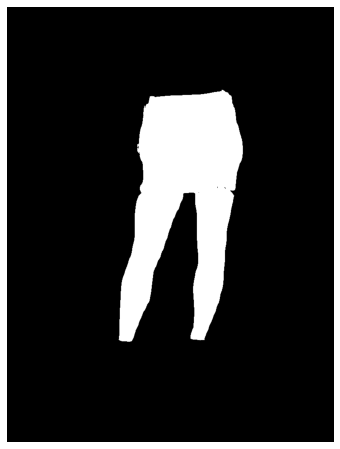

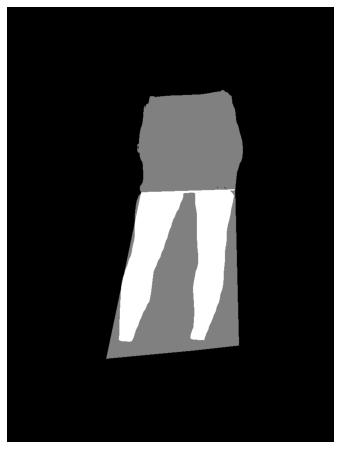

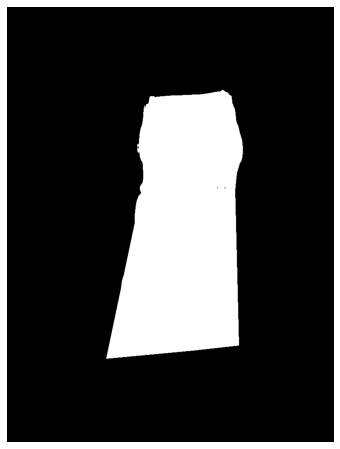

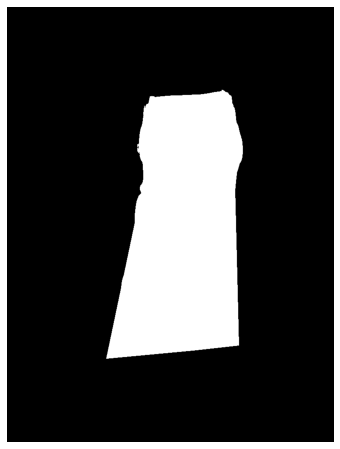

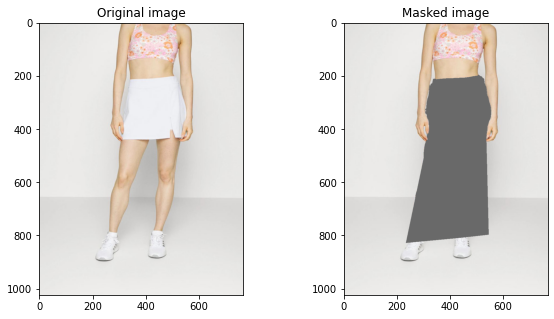

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [39]:
total_func(image['48416_00.jpg'], human_parsing['48416_00.png'], pose_json['48416_00_keypoints.json'])

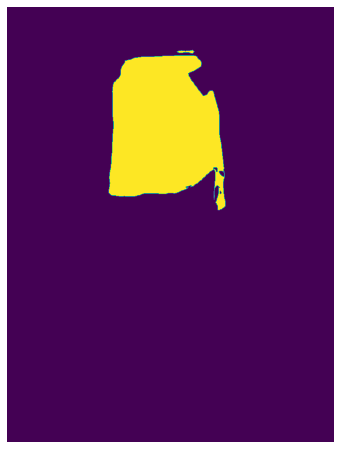

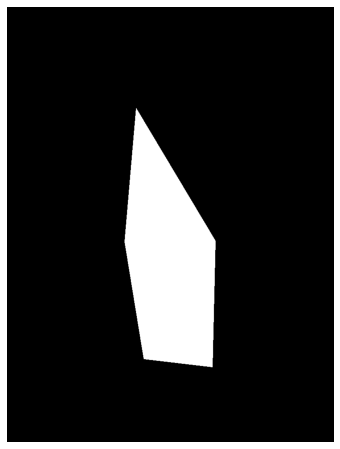

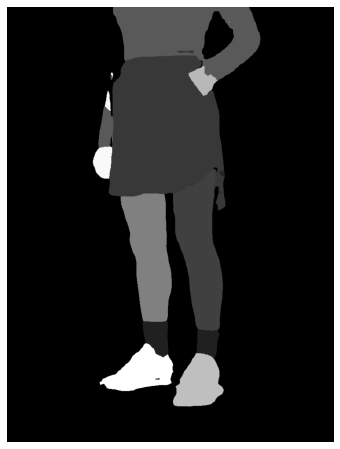

[(303, 238), (436, 238), (462, 827), (482, 847), (349, 808), (371, 828), (326, 552), (439, 550)]
[  0  19  22  34  38  53  76  90 109 113 128 147 151]


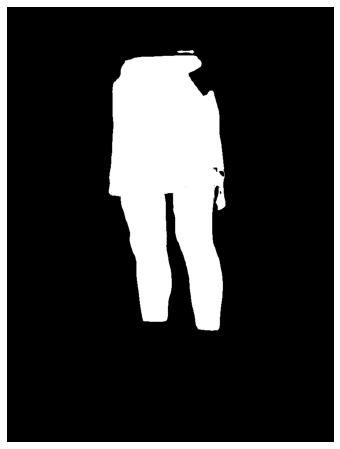

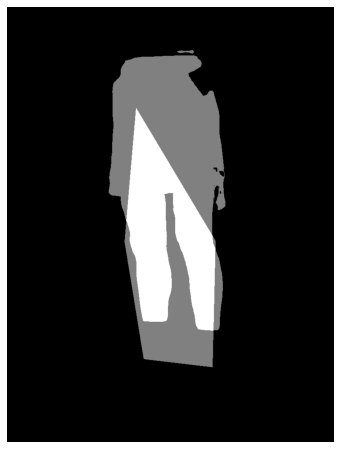

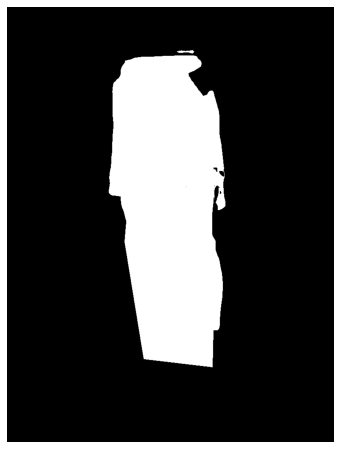

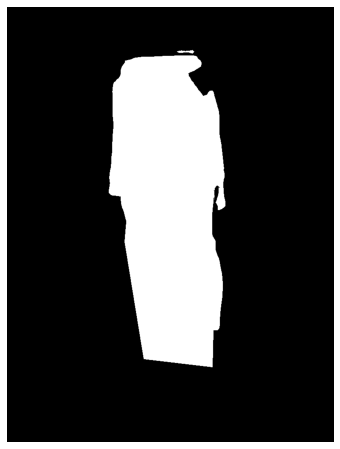

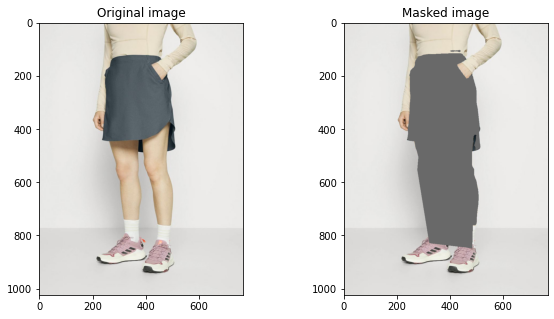

In [40]:
a = total_func(image['48367_00.jpg'], human_parsing['48367_00.png'], pose_json['48367_00_keypoints.json'])

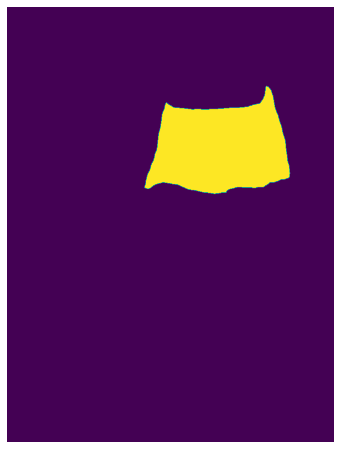

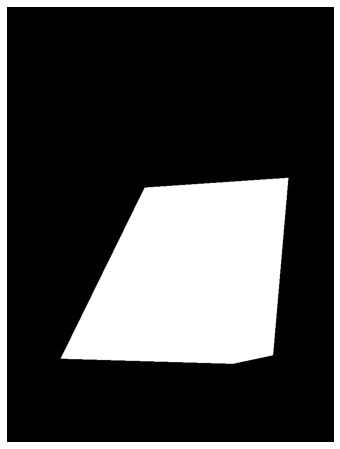

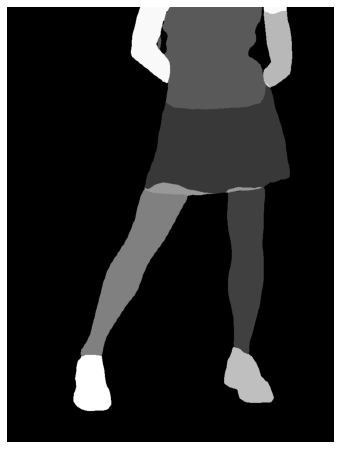

[(422, 261), (564, 261), (552, 819), (530, 839), (196, 819), (176, 827), (323, 547), (564, 541)]
[  0  34  38  53  76  90 109 113 147 151]


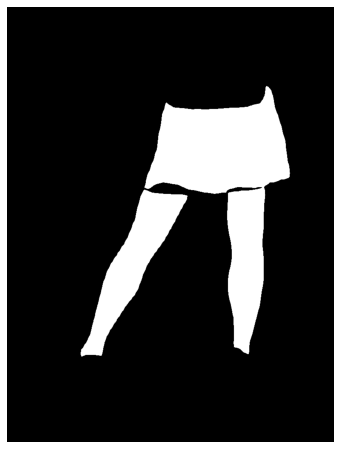

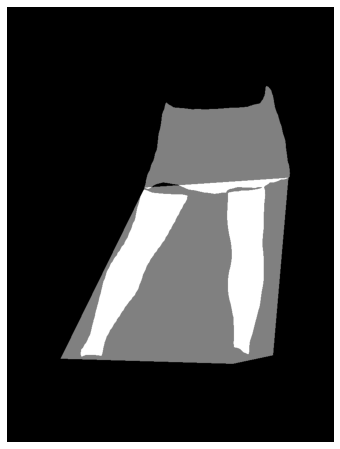

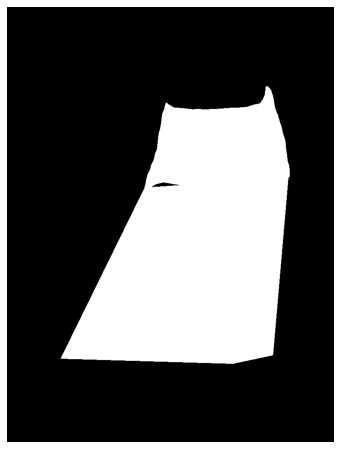

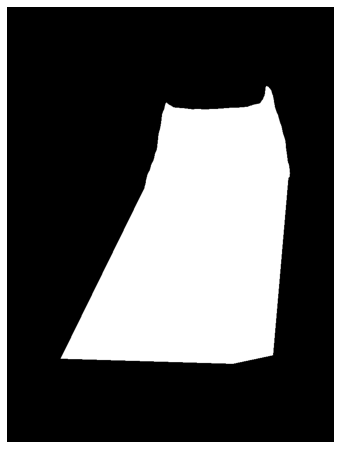

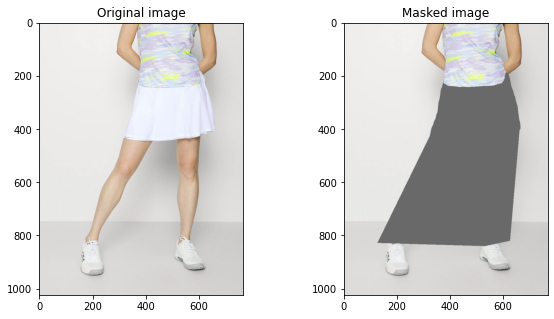

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [41]:
total_func(image['48605_00.jpg'], human_parsing['48605_00.png'], pose_json['48605_00_keypoints.json'])

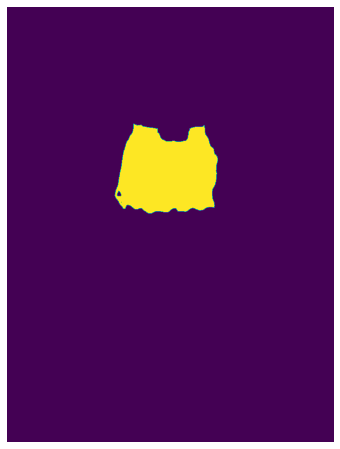

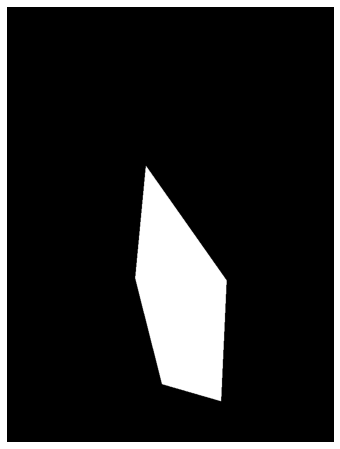

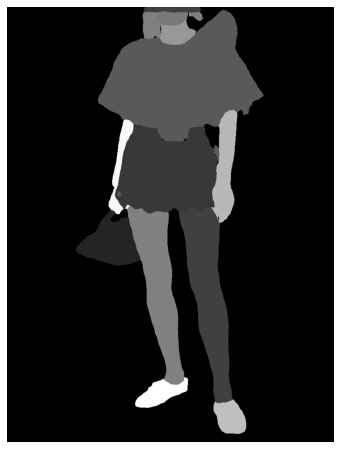

[(326, 374), (439, 377), (510, 915), (502, 927), (394, 870), (414, 887), (351, 638), (465, 643)]
[  0  22  34  38  53  57  72  75  76  90 109 113 147 151]


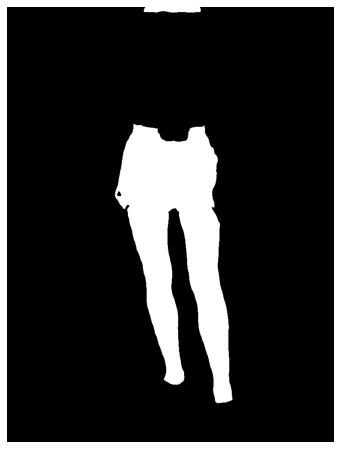

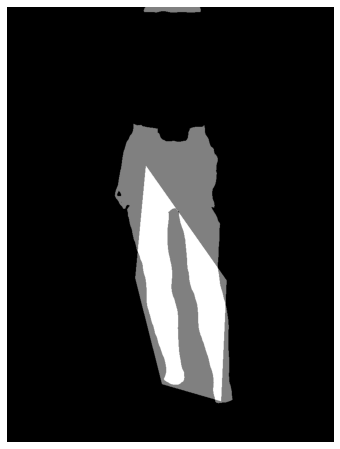

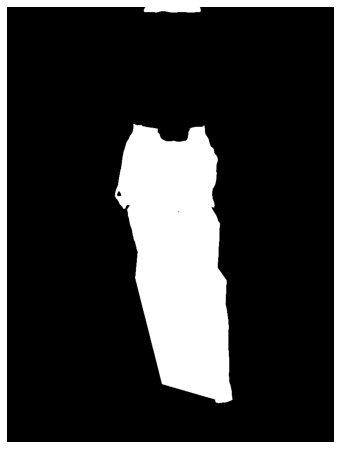

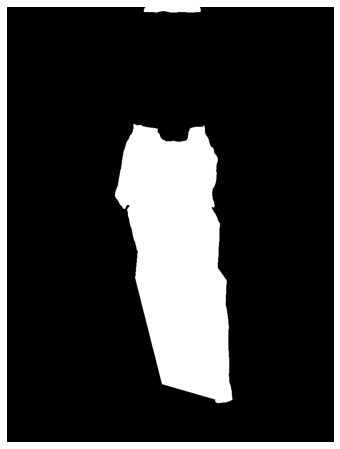

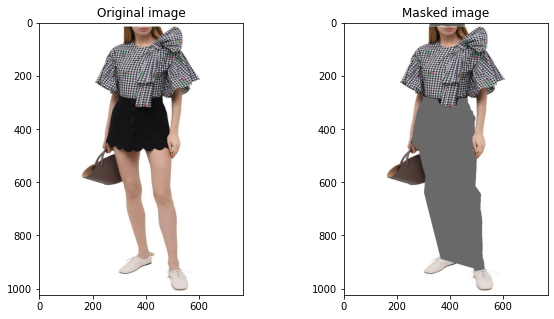

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [42]:
total_func(image['174829_00.jpg'], human_parsing['174829_00.png'], pose_json['174829_00_keypoints.json'])

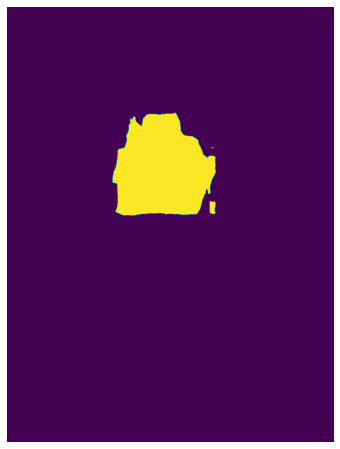

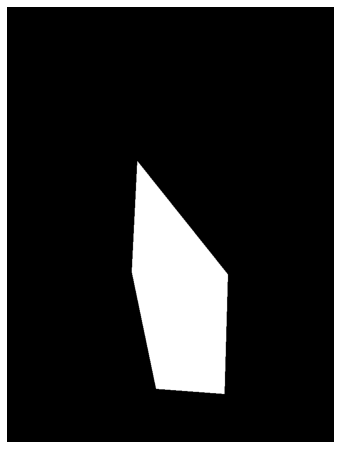

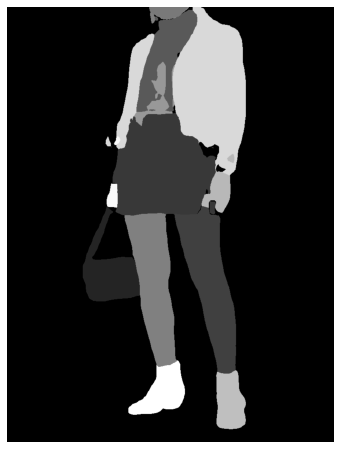

[(306, 363), (434, 371), (521, 895), (510, 910), (374, 884), (400, 898), (343, 623), (468, 629)]
[  0  22  34  38  53  72  75  76  90 109 113 128 147 151]


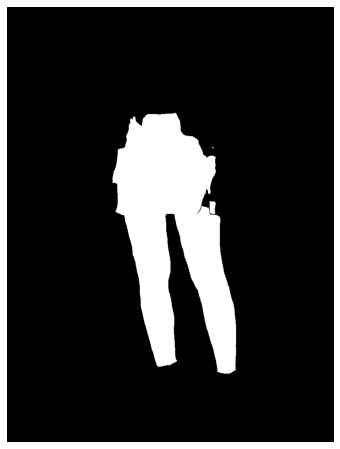

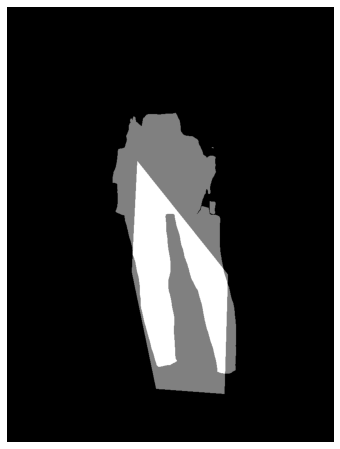

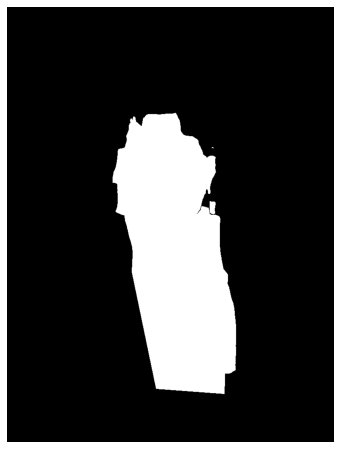

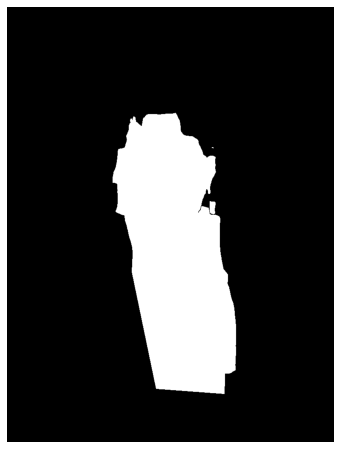

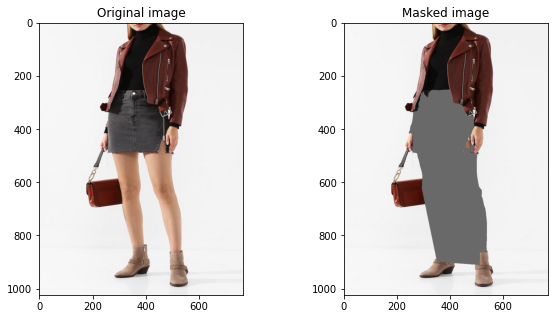

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [45]:
total_func(image['177307_00.jpg'], human_parsing['177307_00.png'], pose_json['177307_00_keypoints.json'])